# Norway Complete Data Pipeline - Phase 1

**Goal:** Generate all 3 datasets (Dataset 2, 3, 4) from raw Dataset 1 in ONE comprehensive notebook

**Dataset:** 35,377 EV charging sessions from 12 Norwegian locations

**Reference:** Sørensen et al., Data in Brief 2024 (PMCID: PMC11404051)

**Timeline:** ~10-12 hours (can be done in sections)

---

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully")
print(f"Pandas: {pd.__version__}")
print(f"NumPy: {np.__version__}")

✅ Libraries imported successfully
Pandas: 2.3.3
NumPy: 1.26.4


---

## SECTION 1: Load & Clean Raw Data

**Objective:** Load Dataset 1 with European formatting and apply Table 5 cleaning rules

**Expected Output:** `norway_sessions_clean.csv` (~32K sessions, 261 users)

In [2]:
# Load raw Dataset 1 with European formatting (semicolon separator, comma decimal)
df = pd.read_csv('../data/Dataset1_charging_reports.csv', 
                 sep=';',           # European format: semicolon separator
                 decimal=',')       # European format: comma decimal

print(f"✅ Dataset loaded: {len(df)} rows")
print(f"\nDataset shape: {df.shape}")
print(f"\nColumn names:")
print(df.dtypes)
print(f"\nFirst few rows:")
df.head(10)

✅ Dataset loaded: 35377 rows

Dataset shape: (35377, 7)

Column names:
location            object
user_id             object
session_id          object
plugin_time         object
plugout_time        object
connection_time    float64
energy_session     float64
dtype: object

First few rows:


,location,user_id,session_id,plugin_time,plugout_time,connection_time,energy_session
0,ASK,ASK_Plass15,ASK_18266,2019-11-28 19:08:00,2019-11-29 08:20:00,13.200000,19.96
1,ASK,ASK_Plass15,ASK_14220,2019-09-02 20:23:00,2019-09-03 07:48:00,11.416670,21.34
2,ASK,ASK_Plass15,ASK_20447,2020-01-08 17:35:00,2020-01-09 07:49:00,14.233330,19.85
3,ASK,ASK_Plass15,ASK_13858,2019-08-23 18:10:00,2019-08-24 09:22:00,15.200000,24.50
4,ASK,ASK_Plass15,ASK_16687,2019-10-30 20:14:00,2019-10-31 08:10:00,11.933330,18.50
5,ASK,ASK_Plass15,ASK_14159,2019-08-31 20:28:00,2019-09-01 09:01:00,12.550000,16.84
6,ASK,ASK_Plass15,ASK_21064,2020-01-20 14:32:00,2020-01-20 16:01:00,1.483333,5.18
7,ASK,ASK_Plass15,ASK_16830,2019-11-02 19:33:00,2019-11-03 10:14:00,14.683330,20.67
8,ASK,ASK_Plass15,ASK_19433,2019-12-18 16:24:00,2019-12-19 08:18:00,15.900000,16.32
9,ASK,ASK_Plass15,ASK_17481,2019-11-14 16:26:00,2019-11-15 08:14:00,15.800000,16.56


In [3]:
# Parse datetime columns
df['plugin_time'] = pd.to_datetime(df['plugin_time'])
df['plugout_time'] = pd.to_datetime(df['plugout_time'])

# Check for missing values
print("Missing values:")
print(df.isnull().sum())

# Basic statistics
print(f"\n{'='*60}")
print("BEFORE CLEANING (Table 5 Rules):")
print(f"{'='*60}")
print(f"Total sessions: {len(df)}")
print(f"Unique users: {df['user_id'].nunique()}")
print(f"Unique locations: {df['location'].nunique()}")
print(f"Locations: {sorted(df['location'].unique())}")
print(f"\nTime range: {df['plugin_time'].min()} to {df['plugin_time'].max()}")
print(f"\nEnergy (kWh) - Min: {df['energy_session'].min():.2f}, Max: {df['energy_session'].max():.2f}, Mean: {df['energy_session'].mean():.2f}")
print(f"Connection time (h) - Min: {df['connection_time'].min():.4f}, Max: {df['connection_time'].max():.2f}, Mean: {df['connection_time'].mean():.2f}")

Missing values:
location            0
user_id             0
session_id          0
plugin_time         0
plugout_time       38
connection_time    38
energy_session      0
dtype: int64

BEFORE CLEANING (Table 5 Rules):
Total sessions: 35377
Unique users: 267
Unique locations: 12
Locations: ['ASK', 'BAR', 'BAR_2', 'BER', 'BOD', 'KRO', 'OSL_1', 'OSL_2', 'OSL_S', 'OSL_T', 'TRO', 'TRO_R']

Time range: 2018-02-06 14:42:00 to 2021-08-05 20:50:00

Energy (kWh) - Min: 0.06, Max: 88.45, Mean: 12.66
Connection time (h) - Min: 0.0339, Max: 119.92, Mean: 12.66


In [4]:
# Apply Table 5 Cleaning Rules from Sørensen et al. 2024

df_clean = df.copy()

# Rule 1: Remove sessions with energy_session ≤ 0.5 kWh or > 150 kWh
print("\nRule 1: Energy filtering")
print(f"  Sessions with energy_session ≤ 0.5: {(df_clean['energy_session'] <= 0.5).sum()}")
print(f"  Sessions with energy_session > 150: {(df_clean['energy_session'] > 150).sum()}")
df_clean = df_clean[(df_clean['energy_session'] > 0.5) & (df_clean['energy_session'] <= 150)]
print(f"  → Remaining: {len(df_clean)}")

# Rule 2: Remove sessions with connection_time < 2 minutes or > 5 days
print("\nRule 2: Connection time filtering")
min_hours = 2 / 60  # 2 minutes in hours
max_hours = 5 * 24  # 5 days in hours
print(f"  Sessions with connection_time < {min_hours:.4f}h: {(df_clean['connection_time'] < min_hours).sum()}")
print(f"  Sessions with connection_time > {max_hours:.2f}h: {(df_clean['connection_time'] > max_hours).sum()}")
df_clean = df_clean[(df_clean['connection_time'] >= min_hours) & (df_clean['connection_time'] <= max_hours)]
print(f"  → Remaining: {len(df_clean)}")

# Rule 3: Calculate average power and remove sessions with avg_power ≥ 11.5 kW
print("\nRule 3: Average power filtering")
df_clean['avg_power'] = df_clean['energy_session'] / df_clean['connection_time']
print(f"  Sessions with avg_power ≥ 11.5 kW: {(df_clean['avg_power'] >= 11.5).sum()}")
df_clean = df_clean[df_clean['avg_power'] < 11.5]
print(f"  → Remaining: {len(df_clean)}")

# Rule 4: Remove users with < 10 sessions
print("\nRule 4: Remove users with < 10 sessions")
user_counts_before = df_clean['user_id'].value_counts()
users_to_keep = user_counts_before[user_counts_before >= 10].index
print(f"  Users with < 10 sessions: {(user_counts_before < 10).sum()}")
df_clean = df_clean[df_clean['user_id'].isin(users_to_keep)]
print(f"  → Remaining: {len(df_clean)}")
print(f"  → Remaining users: {df_clean['user_id'].nunique()}")

print(f"\n{'='*60}")
print("AFTER CLEANING (All Rules Applied):")
print(f"{'='*60}")
print(f"Total sessions: {len(df_clean)}")
print(f"Unique users: {df_clean['user_id'].nunique()}")
print(f"Removed sessions: {len(df) - len(df_clean)} ({100*(len(df) - len(df_clean))/len(df):.1f}%)")
print(f"\nEnergy (kWh) - Min: {df_clean['energy_session'].min():.2f}, Max: {df_clean['energy_session'].max():.2f}, Mean: {df_clean['energy_session'].mean():.2f}")
print(f"Connection time (h) - Min: {df_clean['connection_time'].min():.4f}, Max: {df_clean['connection_time'].max():.2f}, Mean: {df_clean['connection_time'].mean():.2f}")
print(f"Avg power (kW) - Min: {df_clean['avg_power'].min():.2f}, Max: {df_clean['avg_power'].max():.2f}, Mean: {df_clean['avg_power'].mean():.2f}")


Rule 1: Energy filtering
  Sessions with energy_session ≤ 0.5: 439
  Sessions with energy_session > 150: 0
  → Remaining: 34938

Rule 2: Connection time filtering
  Sessions with connection_time < 0.0333h: 0
  Sessions with connection_time > 120.00h: 0
  → Remaining: 34900

Rule 3: Average power filtering
  Sessions with avg_power ≥ 11.5 kW: 0
  → Remaining: 34900

Rule 4: Remove users with < 10 sessions
  Users with < 10 sessions: 1
  → Remaining: 34893
  → Remaining users: 266

AFTER CLEANING (All Rules Applied):
Total sessions: 34893
Unique users: 266
Removed sessions: 484 (1.4%)

Energy (kWh) - Min: 0.51, Max: 88.45, Mean: 12.80
Connection time (h) - Min: 0.0667, Max: 119.92, Mean: 12.74
Avg power (kW) - Min: 0.01, Max: 11.40, Mean: 1.95


In [5]:
# Save cleaned dataset
df_clean.to_csv('../data/norway_sessions_clean.csv', index=False)
print("✅ Saved: ../data/norway_sessions_clean.csv")

# Display distribution by location
print("\nSessions per location (after cleaning):")
print(df_clean['location'].value_counts().sort_index())

✅ Saved: ../data/norway_sessions_clean.csv

Sessions per location (after cleaning):
location
ASK      6275
BAR      1962
BAR_2    1006
BER       297
BOD       506
KRO       491
OSL_1     459
OSL_2     116
OSL_S    9633
OSL_T    5383
TRO      2143
TRO_R    6622
Name: count, dtype: int64


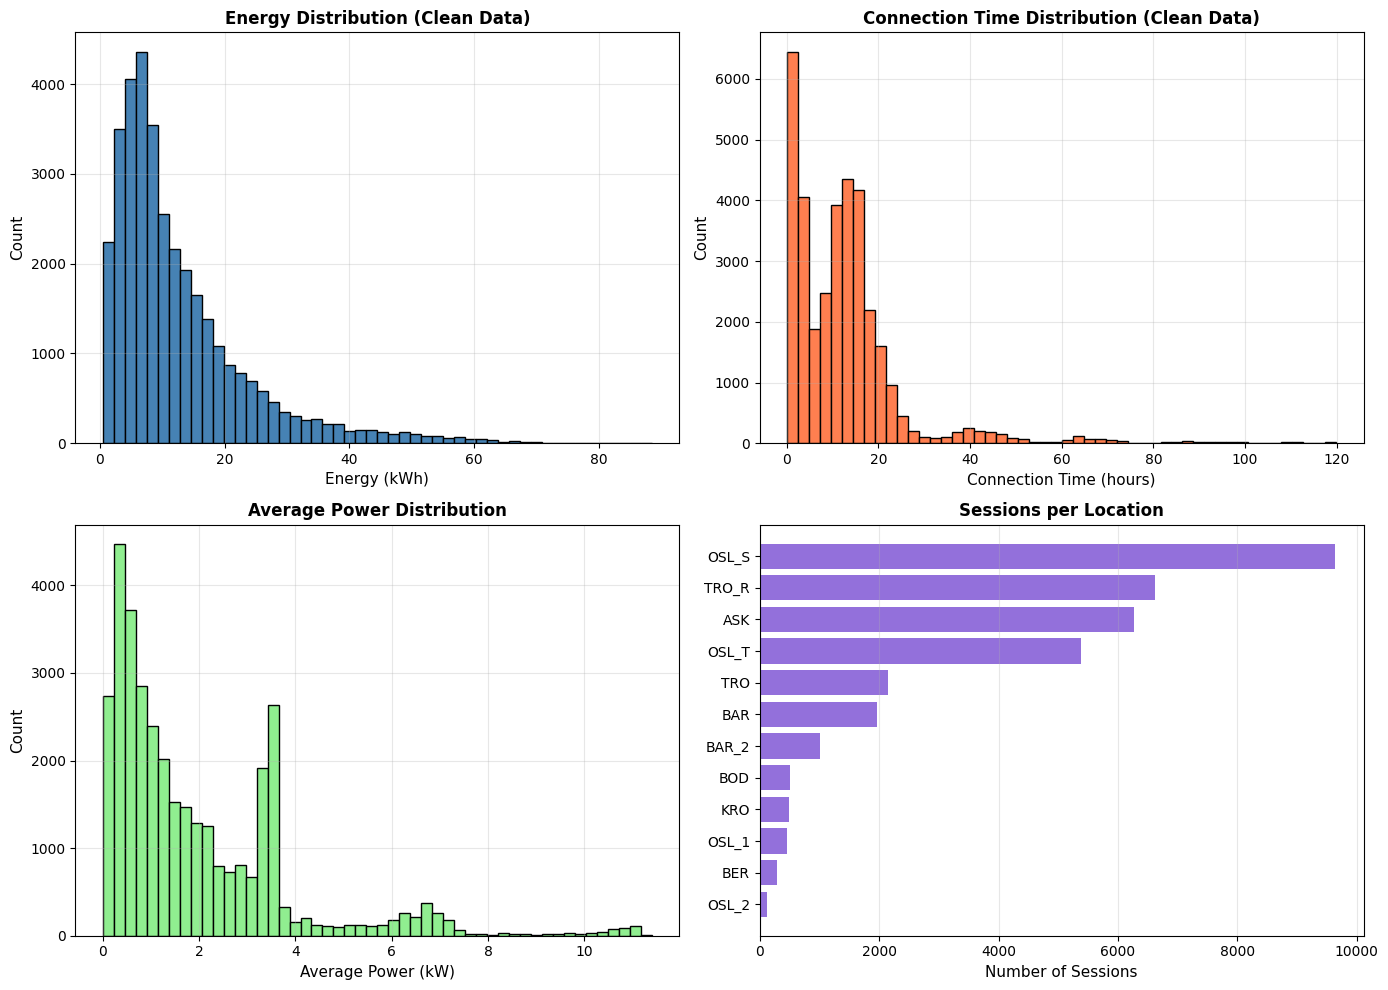


✅ Visualization saved: ../outputs/01_data_distributions.png


In [6]:
# Visualize distributions after cleaning
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Energy distribution
axes[0, 0].hist(df_clean['energy_session'], bins=50, edgecolor='black', color='steelblue')
axes[0, 0].set_xlabel('Energy (kWh)', fontsize=11)
axes[0, 0].set_ylabel('Count', fontsize=11)
axes[0, 0].set_title('Energy Distribution (Clean Data)', fontsize=12, fontweight='bold')
axes[0, 0].grid(alpha=0.3)

# Connection time distribution
axes[0, 1].hist(df_clean['connection_time'], bins=50, edgecolor='black', color='coral')
axes[0, 1].set_xlabel('Connection Time (hours)', fontsize=11)
axes[0, 1].set_ylabel('Count', fontsize=11)
axes[0, 1].set_title('Connection Time Distribution (Clean Data)', fontsize=12, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Average power distribution
axes[1, 0].hist(df_clean['avg_power'], bins=50, edgecolor='black', color='lightgreen')
axes[1, 0].set_xlabel('Average Power (kW)', fontsize=11)
axes[1, 0].set_ylabel('Count', fontsize=11)
axes[1, 0].set_title('Average Power Distribution', fontsize=12, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Sessions per location
location_counts = df_clean['location'].value_counts().sort_values(ascending=True)
axes[1, 1].barh(location_counts.index, location_counts.values, color='mediumpurple')
axes[1, 1].set_xlabel('Number of Sessions', fontsize=11)
axes[1, 1].set_title('Sessions per Location', fontsize=12, fontweight='bold')
axes[1, 1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../outputs/01_data_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Visualization saved: ../outputs/01_data_distributions.png")

---

## SECTION 2: Dataset 2 - User Predictions

**Objective:** Generate user predictions for charging_power and battery_capacity

**Method:** Implement Equations 1-5 from Sørensen et al. 2024

**Expected Output:** `Dataset2_predictions_per_user.csv` with 261 users

In [7]:
print("="*60)
print("DATASET 2: USER PREDICTIONS")
print("="*60)

# Step 1: Calculate charging power per user (Equations 1-3)
print("\nStep 1: Calculate Charging Power (Equations 1-3)")

user_power_predictions = {}

for user_id in df_clean['user_id'].unique():
    user_data = df_clean[df_clean['user_id'] == user_id].copy()
    
    # Calculate average power for each session
    user_data['power'] = user_data['energy_session'] / user_data['connection_time']
    
    # Find maximum power (preliminary prediction)
    max_power = user_data['power'].max()
    
    # Validate against charger levels
    # Level 1: <4 kW, Level 2: 4-8 kW, Level 3: 8-11.5 kW
    if max_power < 4:
        level = 1
    elif max_power < 8:
        level = 2
    else:
        level = 3
    
    user_power_predictions[user_id] = {
        'max_power': max_power,
        'level': level,
        'n_sessions': len(user_data)
    }

# Create DataFrame
power_df = pd.DataFrame.from_dict(user_power_predictions, orient='index')
print(f"\nCharger level distribution:")
print(power_df['level'].value_counts().sort_index())

DATASET 2: USER PREDICTIONS

Step 1: Calculate Charging Power (Equations 1-3)

Charger level distribution:
level
1    114
2    104
3     48
Name: count, dtype: int64

Charger level distribution:
level
1    114
2    104
3     48
Name: count, dtype: int64


In [8]:
# Step 2: Calculate battery capacity per user (Equations 4-5)
print("\nStep 2: Calculate Battery Capacity (Equations 4-5)")

EFFICIENCY = 0.88  # η = 88% efficiency

user_battery_predictions = {}

for user_id in df_clean['user_id'].unique():
    user_data = df_clean[df_clean['user_id'] == user_id].copy()
    
    # Find session with maximum energy
    max_energy_session = user_data['energy_session'].max()
    
    # Calculate battery energy: Ebattery = max_energy × η
    ebattery = max_energy_session * EFFICIENCY
    
    # Determine SoC range based on battery size estimate
    # EV-SM (small/medium): 80% range, EV-L (large): 75% range
    # Assume small/medium if max_energy < 50 kWh
    if ebattery < 50:
        soc_range = 0.80  # 10-90%
    else:
        soc_range = 0.75  # 20-95%
    
    # Calculate capacity: battery_capacity = Ebattery / SoC_range
    battery_capacity = ebattery / soc_range
    
    user_battery_predictions[user_id] = {
        'battery_capacity': battery_capacity,
        'max_energy_session': max_energy_session
    }

# Create battery DataFrame
battery_df = pd.DataFrame.from_dict(user_battery_predictions, orient='index')

# Combine power and battery predictions
dataset2 = pd.DataFrame({
    'user_id': df_clean['user_id'].unique()
})
dataset2 = dataset2.merge(power_df[['max_power']].reset_index().rename(columns={'index': 'user_id', 'max_power': 'charging_power'}),
                          on='user_id', how='left')
dataset2 = dataset2.merge(battery_df[['battery_capacity']].reset_index().rename(columns={'index': 'user_id'}),
                          on='user_id', how='left')

# Sanity checks and filtering
# Remove users with charging_power < 2 kW (market inconsistency)
print(f"\nUsers with charging_power < 2 kW: {(dataset2['charging_power'] < 2).sum()}")
dataset2 = dataset2[dataset2['charging_power'] >= 2]

print(f"\nDataset 2 Summary:")
print(f"Total users with predictions: {len(dataset2)}")
print(f"\nCharging Power (kW) - Min: {dataset2['charging_power'].min():.2f}, Max: {dataset2['charging_power'].max():.2f}, Mean: {dataset2['charging_power'].mean():.2f}")
print(f"Battery Capacity (kWh) - Min: {dataset2['battery_capacity'].min():.2f}, Max: {dataset2['battery_capacity'].max():.2f}, Mean: {dataset2['battery_capacity'].mean():.2f}")

# Save Dataset 2
dataset2.to_csv('../data/Dataset2_predictions_per_user.csv', index=False)
print(f"\n✅ Saved: ../data/Dataset2_predictions_per_user.csv ({len(dataset2)} users)")


Step 2: Calculate Battery Capacity (Equations 4-5)

Users with charging_power < 2 kW: 5

Dataset 2 Summary:
Total users with predictions: 261

Charging Power (kW) - Min: 2.18, Max: 11.40, Mean: 6.04
Battery Capacity (kWh) - Min: 7.16, Max: 103.78, Mean: 39.49

✅ Saved: ../data/Dataset2_predictions_per_user.csv (261 users)


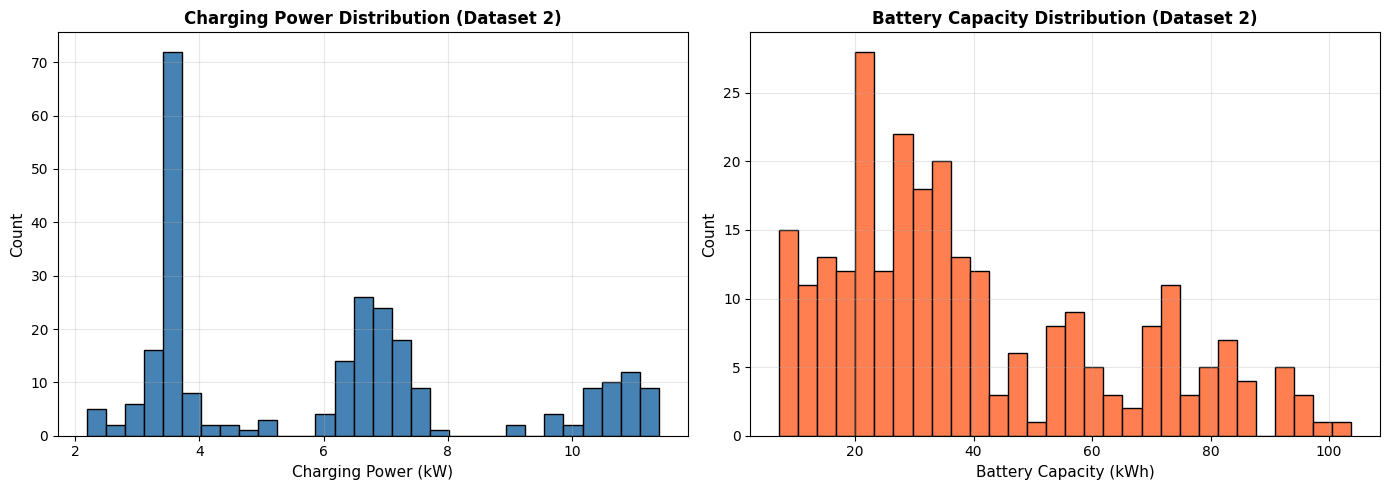

✅ Visualization saved: ../outputs/02_dataset2_distributions.png


In [9]:
# Visualize Dataset 2
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(dataset2['charging_power'], bins=30, edgecolor='black', color='steelblue')
axes[0].set_xlabel('Charging Power (kW)', fontsize=11)
axes[0].set_ylabel('Count', fontsize=11)
axes[0].set_title('Charging Power Distribution (Dataset 2)', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)

axes[1].hist(dataset2['battery_capacity'], bins=30, edgecolor='black', color='coral')
axes[1].set_xlabel('Battery Capacity (kWh)', fontsize=11)
axes[1].set_ylabel('Count', fontsize=11)
axes[1].set_title('Battery Capacity Distribution (Dataset 2)', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/02_dataset2_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualization saved: ../outputs/02_dataset2_distributions.png")

---

## SECTION 3: Dataset 3 - Session Predictions

**Objective:** Generate per-session predictions for charging_time, idle_time, and SoC values

**Method:** Implement Equations 6-11 from Sørensen et al. 2024

**Expected Output:** `Dataset3_predictions_per_session.csv` with ~34K sessions

In [10]:
print("\n" + "="*60)
print("DATASET 3: SESSION PREDICTIONS")
print("="*60)

# Merge session data with user predictions
df_sessions = df_clean.merge(dataset2, on='user_id', how='inner')
print(f"\nSessions with valid user predictions: {len(df_sessions)}")

# Step 1: Calculate charging_time (Equation 7)
print("\nStep 1: Calculate Charging Time (Equation 7)")
df_sessions['charging_time'] = df_sessions['energy_session'] / (df_sessions['charging_power'] * EFFICIENCY)

# If charging_time > connection_time, set to NA (invalid assumption)
invalid_charging = (df_sessions['charging_time'] > df_sessions['connection_time']).sum()
df_sessions.loc[df_sessions['charging_time'] > df_sessions['connection_time'], 'charging_time'] = np.nan
print(f"Sessions with charging_time > connection_time (set to NA): {invalid_charging}")

# Step 2: Calculate idle_time (Equation 8)
print("\nStep 2: Calculate Idle Time (Equation 8)")
df_sessions['idle_time'] = df_sessions['connection_time'] - df_sessions['charging_time']
df_sessions.loc[df_sessions['idle_time'] < 0, 'idle_time'] = 0  # Ensure non-negative

# Step 3: Calculate idle_session (Equation 9)
print("\nStep 3: Calculate Idle Energy Capacity (Equation 9)")
df_sessions['idle_session'] = df_sessions['idle_time'] * df_sessions['charging_power']

# Step 4: Calculate non-flexible sessions
print("\nStep 4: Identify Non-Flexible Sessions (idle_time < 1 hour)")
df_sessions['non_flex_session'] = np.where(df_sessions['idle_time'] < 1, 
                                           df_sessions['energy_session'], 
                                           0)
flexibility_pct = 100 * (df_sessions['idle_time'] >= 1).sum() / len(df_sessions)
print(f"Sessions with idle_time ≥ 1h (flexible): {(df_sessions['idle_time'] >= 1).sum()} ({flexibility_pct:.1f}%)")

# Step 5: Calculate SoC (State of Charge) values (Equation 11)
print("\nStep 5: Calculate State of Charge (SoC) Values (Equation 11)")

# SoC_diff: Change in SoC during session
df_sessions['SoC_diff'] = (df_sessions['energy_session'] * EFFICIENCY) / df_sessions['battery_capacity'] * 100

# SoC_start: Assuming final SoC = 95%
df_sessions['SoC_start'] = 95 - df_sessions['SoC_diff']

# Clip SoC values to valid range [0, 100]
df_sessions['SoC_start'] = df_sessions['SoC_start'].clip(0, 100)
df_sessions['SoC_end'] = (df_sessions['SoC_start'] + df_sessions['SoC_diff']).clip(0, 100)

# Select columns for Dataset 3
dataset3_cols = ['user_id', 'session_id', 'location', 'plugin_time', 'plugout_time',
                 'connection_time', 'energy_session', 'charging_power', 'battery_capacity',
                 'charging_time', 'idle_time', 'idle_session', 'non_flex_session',
                 'SoC_diff', 'SoC_start', 'SoC_end', 'avg_power']

dataset3 = df_sessions[dataset3_cols].copy()

print(f"\nDataset 3 Summary:")
print(f"Total sessions: {len(dataset3)}")
print(f"Sessions with valid charging_time: {dataset3['charging_time'].notna().sum()}")
print(f"\nCharging Time (h) - Mean: {dataset3['charging_time'].mean():.2f}, Median: {dataset3['charging_time'].median():.2f}")
print(f"Idle Time (h) - Mean: {dataset3['idle_time'].mean():.2f}, Median: {dataset3['idle_time'].median():.2f}")
print(f"SoC_diff (%) - Mean: {dataset3['SoC_diff'].mean():.2f}, Range: [{dataset3['SoC_diff'].min():.1f}, {dataset3['SoC_diff'].max():.1f}]")
print(f"SoC_start (%) - Mean: {dataset3['SoC_start'].mean():.2f}, Range: [{dataset3['SoC_start'].min():.1f}, {dataset3['SoC_start'].max():.1f}]")

# Save Dataset 3
dataset3.to_csv('../data/Dataset3_predictions_per_session.csv', index=False)
print(f"\n✅ Saved: ../data/Dataset3_predictions_per_session.csv ({len(dataset3)} sessions)")


DATASET 3: SESSION PREDICTIONS

Sessions with valid user predictions: 34142

Step 1: Calculate Charging Time (Equation 7)
Sessions with charging_time > connection_time (set to NA): 5939

Step 2: Calculate Idle Time (Equation 8)

Step 3: Calculate Idle Energy Capacity (Equation 9)

Step 4: Identify Non-Flexible Sessions (idle_time < 1 hour)
Sessions with idle_time ≥ 1h (flexible): 24955 (73.1%)

Step 5: Calculate State of Charge (SoC) Values (Equation 11)

Dataset 3 Summary:
Total sessions: 34142
Sessions with valid charging_time: 28203

Charging Time (h) - Mean: 3.10, Median: 2.50
Idle Time (h) - Mean: 11.59, Median: 9.31
SoC_diff (%) - Mean: 33.69, Range: [0.6, 80.0]
SoC_start (%) - Mean: 61.31, Range: [15.0, 94.4]

✅ Saved: ../data/Dataset3_predictions_per_session.csv (34142 sessions)

✅ Saved: ../data/Dataset3_predictions_per_session.csv (34142 sessions)


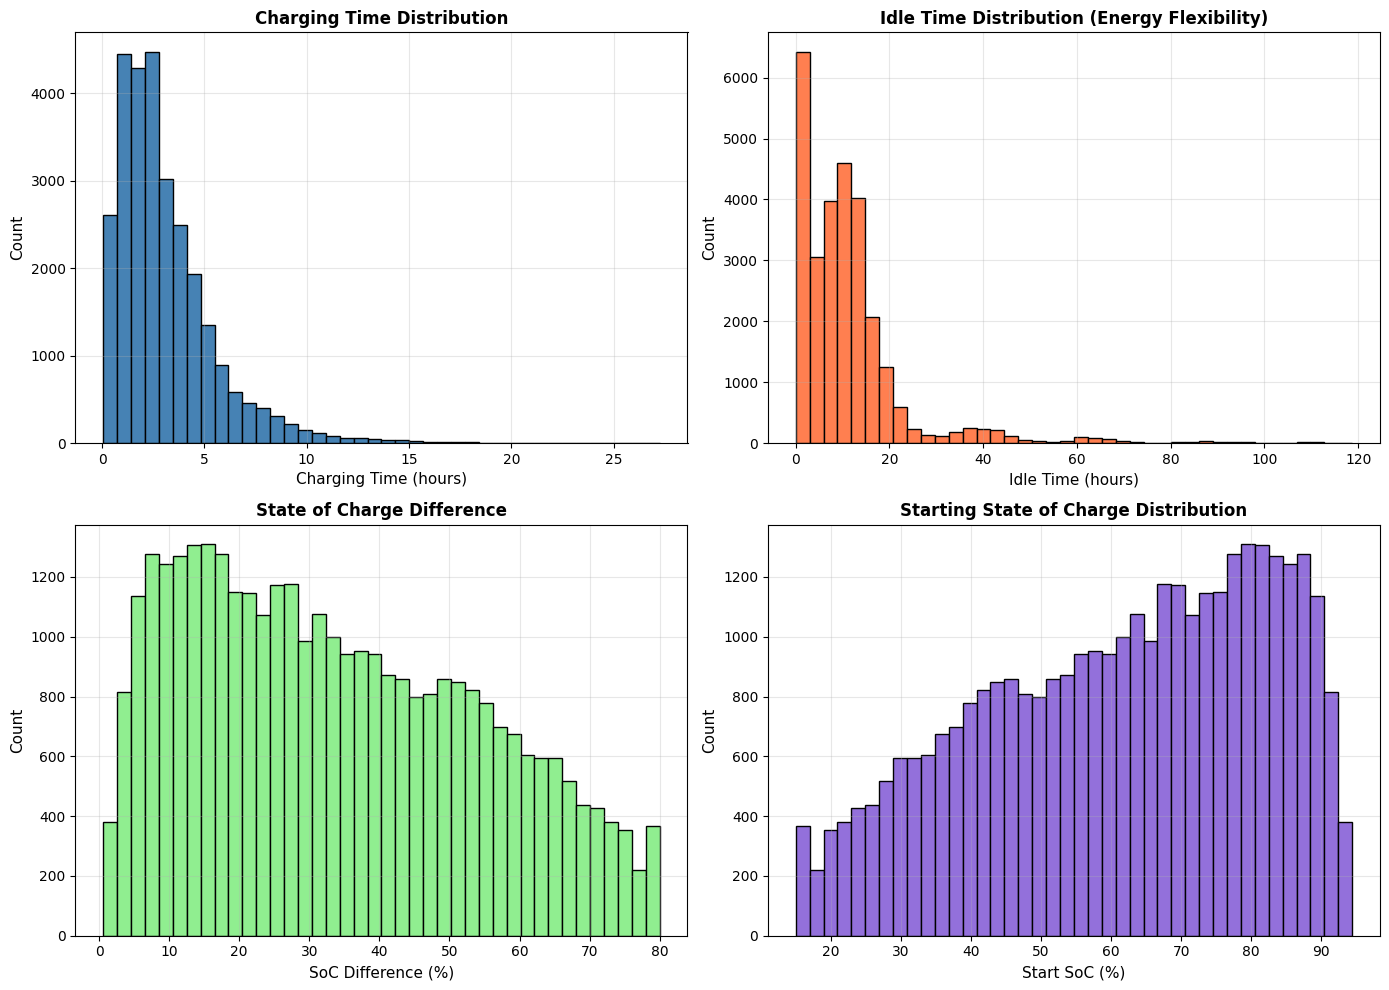

✅ Visualization saved: ../outputs/03_dataset3_distributions.png


In [11]:
# Visualize Dataset 3
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].hist(dataset3['charging_time'].dropna(), bins=40, edgecolor='black', color='steelblue')
axes[0, 0].set_xlabel('Charging Time (hours)', fontsize=11)
axes[0, 0].set_ylabel('Count', fontsize=11)
axes[0, 0].set_title('Charging Time Distribution', fontsize=12, fontweight='bold')
axes[0, 0].grid(alpha=0.3)

axes[0, 1].hist(dataset3['idle_time'], bins=40, edgecolor='black', color='coral')
axes[0, 1].set_xlabel('Idle Time (hours)', fontsize=11)
axes[0, 1].set_ylabel('Count', fontsize=11)
axes[0, 1].set_title('Idle Time Distribution (Energy Flexibility)', fontsize=12, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

axes[1, 0].hist(dataset3['SoC_diff'], bins=40, edgecolor='black', color='lightgreen')
axes[1, 0].set_xlabel('SoC Difference (%)', fontsize=11)
axes[1, 0].set_ylabel('Count', fontsize=11)
axes[1, 0].set_title('State of Charge Difference', fontsize=12, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

axes[1, 1].hist(dataset3['SoC_start'], bins=40, edgecolor='black', color='mediumpurple')
axes[1, 1].set_xlabel('Start SoC (%)', fontsize=11)
axes[1, 1].set_ylabel('Count', fontsize=11)
axes[1, 1].set_title('Starting State of Charge Distribution', fontsize=12, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/03_dataset3_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualization saved: ../outputs/03_dataset3_distributions.png")

---

## SECTION 4: Dataset 4 - Hourly Predictions

**Objective:** Expand each session into hourly granularity

**Method:** Implement Equations 6, 9-11 applied hourly

**Expected Output:** `Dataset4_hourly_predictions.parquet` (~500K+ hours)

In [12]:
print("\n" + "="*60)
print("DATASET 4: HOURLY PREDICTIONS")
print("="*60)

# Create hourly data by expanding each session
hourly_data = []

for idx, row in dataset3.iterrows():
    if idx % 5000 == 0:
        print(f"Processing session {idx}/{len(dataset3)}...")
    
    plugin_time = row['plugin_time']
    plugout_time = row['plugout_time']
    
    # Create hourly timestamps
    current_time = plugin_time.replace(minute=0, second=0, microsecond=0)
    
    charging_time = row['charging_time']
    connection_time = row['connection_time']
    energy_session = row['energy_session']
    charging_power = row['charging_power']
    battery_capacity = row['battery_capacity']
    
    remaining_energy = energy_session
    remaining_charging_time = charging_time if pd.notna(charging_time) else connection_time
    
    hour_num = 0
    
    while current_time < plugout_time:
        next_time = current_time + timedelta(hours=1)
        
        # Determine how much time falls within this hour
        if hour_num == 0:
            hour_duration = (next_time - plugin_time).total_seconds() / 3600
        else:
            hour_duration = min(1.0, (plugout_time - current_time).total_seconds() / 3600)
        
        # Calculate energy charged this hour
        if remaining_charging_time > 0 and remaining_energy > 0:
            energy_charged_i = min(charging_power * hour_duration, remaining_energy)
            remaining_energy -= energy_charged_i
            remaining_charging_time -= hour_duration
        else:
            energy_charged_i = 0
        
        # Idle energy capacity during this hour
        if remaining_charging_time <= 0 and remaining_energy <= 0:
            # In idle phase
            energy_idle_i = charging_power * hour_duration
        else:
            energy_idle_i = 0
        
        # Connected energy = charged + idle
        energy_connected_i = energy_charged_i + energy_idle_i
        
        # SoC calculations
        SoC_diff_i = (energy_charged_i * EFFICIENCY) / battery_capacity * 100
        SoC_from_i = row['SoC_start']  # Simplified: use session start
        SoC_to_i = SoC_from_i + SoC_diff_i
        SoC_to_i = min(SoC_to_i, 100)  # Cap at 100%
        
        hourly_data.append({
            'user_id': row['user_id'],
            'session_id': row['session_id'],
            'date_from': current_time,
            'energy_charged_i': energy_charged_i,
            'energy_idle_i': energy_idle_i,
            'energy_connected_i': energy_connected_i,
            'SoC_diff_i': SoC_diff_i,
            'SoC_from_i': SoC_from_i,
            'SoC_to_i': SoC_to_i
        })
        
        current_time = next_time
        hour_num += 1

# Create Dataset 4
dataset4 = pd.DataFrame(hourly_data)

print(f"\nDataset 4 Summary:")
print(f"Total hourly records: {len(dataset4)}")
print(f"Average hours per session: {len(dataset4) / len(dataset3):.2f}")
print(f"\nEnergy Charged (kWh) - Mean: {dataset4['energy_charged_i'].mean():.2f}")
print(f"Energy Idle (kWh) - Mean: {dataset4['energy_idle_i'].mean():.2f}")
print(f"Energy Connected (kWh) - Mean: {dataset4['energy_connected_i'].mean():.2f}")
print(f"SoC_diff (%) - Mean: {dataset4['SoC_diff_i'].mean():.2f}")

# Save Dataset 4 (use CSV.GZ for efficient storage)
dataset4.to_csv('../data/Dataset4_hourly_predictions.csv.gz', index=False, compression='gzip')
print(f"\n✅ Saved: ../data/Dataset4_hourly_predictions.csv.gz ({len(dataset4)} hourly records)")


DATASET 4: HOURLY PREDICTIONS
Processing session 0/34142...
Processing session 5000/34142...
Processing session 10000/34142...
Processing session 15000/34142...
Processing session 20000/34142...
Processing session 25000/34142...
Processing session 30000/34142...

Dataset 4 Summary:
Total hourly records: 462379
Average hours per session: 13.54

Energy Charged (kWh) - Mean: 0.95
Energy Idle (kWh) - Mean: 2.68
Energy Connected (kWh) - Mean: 3.63
SoC_diff (%) - Mean: 2.49

✅ Saved: ../data/Dataset4_hourly_predictions.csv.gz (462379 hourly records)


---

## SECTION 5: Feature Engineering for ML

**Objective:** Merge all datasets and create features for neural network training

**Expected Output:** `norway_ml_features.csv` ready for Phase 2 (neural network training)

In [13]:
print("\n" + "="*60)
print("SECTION 5: FEATURE ENGINEERING FOR ML")
print("="*60)

# Create ML feature set from Dataset 3
ml_features = dataset3.copy()

# Temporal features
print("\nAdding temporal features...")
ml_features['hour'] = ml_features['plugin_time'].dt.hour
ml_features['day_of_week'] = ml_features['plugin_time'].dt.dayofweek
ml_features['month'] = ml_features['plugin_time'].dt.month
ml_features['is_weekend'] = ml_features['day_of_week'].isin([5, 6]).astype(int)

# Time-of-day features (sin/cos for circularity)
ml_features['hour_sin'] = np.sin(2 * np.pi * ml_features['hour'] / 24)
ml_features['hour_cos'] = np.cos(2 * np.pi * ml_features['hour'] / 24)
ml_features['month_sin'] = np.sin(2 * np.pi * ml_features['month'] / 12)
ml_features['month_cos'] = np.cos(2 * np.pi * ml_features['month'] / 12)

# User history features
print("Adding user history features...")
user_avg_energy = df_clean.groupby('user_id')['energy_session'].agg(['mean', 'std']).reset_index()
user_avg_energy.columns = ['user_id', 'user_avg_energy', 'user_std_energy']
ml_features = ml_features.merge(user_avg_energy, on='user_id', how='left')

user_avg_connection = df_clean.groupby('user_id')['connection_time'].agg(['mean']).reset_index()
user_avg_connection.columns = ['user_id', 'user_avg_connection_time']
ml_features = ml_features.merge(user_avg_connection, on='user_id', how='left')

# Location features (one-hot)
print("Adding location features...")
location_dummies = pd.get_dummies(ml_features['location'], prefix='loc')
ml_features = pd.concat([ml_features, location_dummies], axis=1)

# Classification target: Long (≥24h) vs Short (<24h)
print("Adding classification target...")
ml_features['is_long_session'] = (ml_features['connection_time'] >= 24).astype(int)

print(f"\nML Feature Set Summary:")
print(f"Total features created: {len(ml_features.columns)}")
print(f"Long sessions: {ml_features['is_long_session'].sum()} ({100*ml_features['is_long_session'].mean():.1f}%)")
print(f"Short sessions: {(1-ml_features['is_long_session']).sum()} ({100*(1-ml_features['is_long_session']).mean():.1f}%)")

# Save ML features
ml_features.to_csv('../data/norway_ml_features.csv', index=False)
print(f"\n✅ Saved: ../data/norway_ml_features.csv ({len(ml_features)} samples, {len(ml_features.columns)} features)")


SECTION 5: FEATURE ENGINEERING FOR ML

Adding temporal features...
Adding user history features...
Adding location features...
Adding classification target...

ML Feature Set Summary:
Total features created: 41
Long sessions: 2677 (7.8%)
Short sessions: 31465 (92.2%)

✅ Saved: ../data/norway_ml_features.csv (34142 samples, 41 features)


In [14]:
# Final summary
print("\n" + "="*70)
print("PHASE 1 COMPLETE - ALL DATASETS GENERATED!")
print("="*70)

print(f"""
✅ Dataset 1 (Raw): {len(df):,} sessions
✅ Dataset 1 (Cleaned): {len(df_clean):,} sessions
✅ Dataset 2 (User Predictions): {len(dataset2)} users
✅ Dataset 3 (Session Predictions): {len(dataset3):,} sessions
✅ Dataset 4 (Hourly Predictions): {len(dataset4):,} hourly records
✅ ML Features: {len(ml_features):,} samples with {len(ml_features.columns)} features

Files saved:
  - data/norway_sessions_clean.csv
  - data/Dataset2_predictions_per_user.csv
  - data/Dataset3_predictions_per_session.csv
  - data/Dataset4_hourly_predictions.parquet
  - data/norway_ml_features.csv

Visualizations saved:
  - outputs/01_data_distributions.png
  - outputs/02_dataset2_distributions.png
  - outputs/03_dataset3_distributions.png

Ready for PHASE 2: Neural Network Training! 🚀
""")

print("Key Statistics for Presentation:")
print(f"  • Energy flexibility: {100*(dataset3['idle_time']>=1).mean():.1f}% sessions have ≥1h idle time")
print(f"  • Average charging time: {dataset3['charging_time'].mean():.1f} hours")
print(f"  • Average idle time: {dataset3['idle_time'].mean():.1f} hours")
print(f"  • Most common charging power: {dataset2['charging_power'].mode()[0]:.1f} kW")
print(f"  • Battery capacity range: {dataset2['battery_capacity'].min():.0f}-{dataset2['battery_capacity'].max():.0f} kWh")


PHASE 1 COMPLETE - ALL DATASETS GENERATED!

✅ Dataset 1 (Raw): 35,377 sessions
✅ Dataset 1 (Cleaned): 34,893 sessions
✅ Dataset 2 (User Predictions): 261 users
✅ Dataset 3 (Session Predictions): 34,142 sessions
✅ Dataset 4 (Hourly Predictions): 462,379 hourly records
✅ ML Features: 34,142 samples with 41 features

Files saved:
  - data/norway_sessions_clean.csv
  - data/Dataset2_predictions_per_user.csv
  - data/Dataset3_predictions_per_session.csv
  - data/Dataset4_hourly_predictions.parquet
  - data/norway_ml_features.csv

Visualizations saved:
  - outputs/01_data_distributions.png
  - outputs/02_dataset2_distributions.png
  - outputs/03_dataset3_distributions.png

Ready for PHASE 2: Neural Network Training! 🚀

Key Statistics for Presentation:
  • Energy flexibility: 73.1% sessions have ≥1h idle time
  • Average charging time: 3.1 hours
  • Average idle time: 11.6 hours
  • Most common charging power: 3.5 kW
  • Battery capacity range: 7-104 kWh
